In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import  StandardScaler, LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

In [2]:
# Load data
train = pd.read_csv('train.csv')
labels = pd.read_csv('trainLabels.csv')

# Merge data
data = pd.merge(train, labels, on='id')
data.head()

,id,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,y24,y25,y26,y27,y28,y29,y30,y31,y32,y33
0,1,NO,NO,dqOiM6yBYgnVSezBRiQXs9bvOFnRqrtIoXRIElxD7g8=,GNjrXXA3SxbgD0dTRblAPO9jFJ7AIaZnu/f48g5XSUk=,0.576561,0.073139,0.481394,0.115697,0.472474,...,0,0,0,0,0,0,0,0,0,1
1,2,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
2,3,NO,NO,ib4VpsEsqJHzDiyL0dZLQ+xQzDPrkxE+9T3mx5fv2wI=,X6dDAI/DZOWvu0Dg6gCgRoNr2vTUz/mc4SdHTNUPS38=,1.341803,0.051422,0.935572,0.041440,0.501710,...,0,0,0,0,0,0,0,0,0,0
3,4,YES,NO,BfrqME7vdLw3suQp6YAT16W2piNUmpKhMzuDrVrFQ4w=,YGCdISifn4fLao/ASKdZFhGIq23oqzfSbUVb6px1pig=,0.653912,0.041471,0.940787,0.090851,0.556564,...,0,0,0,0,0,0,0,0,0,1
4,5,NO,NO,RTjsrrR8DTlJyaIP9Q3Z8s0zseqlVQTrlSe97GCWfbk=,3yK2OPj1uYDsoMgsxsjY1FxXkOllD8Xfh20VYGqT+nU=,1.415919,0.000000,1.000000,0.000000,0.375297,...,0,0,0,0,0,0,0,0,0,1


In [3]:
data.shape

(9999, 179)

## EDA

In [4]:
# drop irrelevent columns
data = data.drop(columns=['id'],axis=1)
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y24,y25,y26,y27,y28,y29,y30,y31,y32,y33
0,NO,NO,dqOiM6yBYgnVSezBRiQXs9bvOFnRqrtIoXRIElxD7g8=,GNjrXXA3SxbgD0dTRblAPO9jFJ7AIaZnu/f48g5XSUk=,0.576561,0.073139,0.481394,0.115697,0.472474,YES,...,0,0,0,0,0,0,0,0,0,1
1,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0,0,0,0,0,0,0,0,1,0
2,NO,NO,ib4VpsEsqJHzDiyL0dZLQ+xQzDPrkxE+9T3mx5fv2wI=,X6dDAI/DZOWvu0Dg6gCgRoNr2vTUz/mc4SdHTNUPS38=,1.341803,0.051422,0.935572,0.041440,0.501710,NO,...,0,0,0,0,0,0,0,0,0,0
3,YES,NO,BfrqME7vdLw3suQp6YAT16W2piNUmpKhMzuDrVrFQ4w=,YGCdISifn4fLao/ASKdZFhGIq23oqzfSbUVb6px1pig=,0.653912,0.041471,0.940787,0.090851,0.556564,YES,...,0,0,0,0,0,0,0,0,0,1
4,NO,NO,RTjsrrR8DTlJyaIP9Q3Z8s0zseqlVQTrlSe97GCWfbk=,3yK2OPj1uYDsoMgsxsjY1FxXkOllD8Xfh20VYGqT+nU=,1.415919,0.000000,1.000000,0.000000,0.375297,NO,...,0,0,0,0,0,0,0,0,0,1


In [5]:
print(f"Shape of 'data' : {data.shape}")

Shape of 'data' : (9999, 178)


In [6]:
# duplicated rows
print(f"No. of duplicated rows : {data.duplicated().sum()}")

No. of duplicated rows : 95


In [7]:
data = data.drop_duplicates()
print(f"No. of duplicated rows : {data.duplicated().sum()}")

No. of duplicated rows : 0


In [8]:
# handelling missing values

print(f"No of missing values : {data.isnull().sum()}")
print(f"Total no of missing values : {data.isnull().sum().sum()}")

No of missing values : x1     1416
x2     1416
x3     1416
x4     1416
x5        0
       ... 
y29       0
y30       0
y31       0
y32       0
y33       0
Length: 178, dtype: int64
Total no of missing values : 34980


In [10]:
# Separate numerical and categorical columns
numerical_cols = data.select_dtypes(include=['number']).columns
categorical_cols = data.select_dtypes(exclude=['number']).columns

# Fill missing values with median for numerical columns
df_filled_numerical = data[numerical_cols].fillna(data[numerical_cols].median())

# Fill missing values with mode for categorical columns
df_filled_categorical = data[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Concatenate back together
data = pd.concat([df_filled_numerical, df_filled_categorical], axis=1)

print(f"No of missing values : {data.isnull().sum().sum()}")

No of missing values : 0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9904 entries, 0 to 9998
Columns: 178 entries, x5 to x142
dtypes: float64(55), int64(63), object(60)
memory usage: 13.5+ MB


In [12]:
# text column name in data
text_column = 'x3'  

# Bag of Words (CountVectorizer)
count_vectorizer = CountVectorizer()
bow_features1 = count_vectorizer.fit_transform(data[text_column])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_features1 = tfidf_vectorizer.fit_transform(data[text_column])

# Word Embeddings (Word2Vec)
# First, tokenize the text into sentences (list of words)
tokenized_sentences1 = [text.split() for text in data[text_column]]

# Train Word2Vec model
word2vec_model = Word2Vec(tokenized_sentences1, vector_size=100, window=5, min_count=1, sg=1)

# Convert text to word embeddings
word_embeddings1 = []
for sentence in tokenized_sentences1:
    embeddings = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if embeddings:
        mean_embedding = sum(embeddings) / len(embeddings)
        word_embeddings1.append(mean_embedding)
    else:
        # If no word in the sentence is present in the vocabulary, use zeros as embeddings
        word_embeddings1.append([0] * 100)  # Assuming vector_size=100

word_embeddings1 = pd.DataFrame(word_embeddings1)


In [13]:
word_embeddings1.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.001946,-0.008691,0.006825,-0.006586,-0.004273,-0.004213,0.004054,-0.004314,0.008745,-0.003326,...,-0.005091,0.008670,0.006880,0.000080,-0.004661,0.004794,-0.009308,-0.009236,0.003094,0.005254
1,-0.000536,0.000236,0.005103,0.009009,-0.009303,-0.007117,0.006459,0.008973,-0.005015,-0.003763,...,0.001631,0.000190,0.003474,0.000218,0.009619,0.005061,-0.008917,-0.007042,0.000901,0.006393
2,0.008132,-0.004457,-0.001068,0.001006,-0.000191,0.001148,0.006114,-0.000020,-0.003246,-0.001511,...,-0.002701,0.000444,-0.003537,-0.000419,-0.000709,0.000823,0.008195,-0.005737,-0.001660,0.005572
3,-0.005331,0.007790,0.005648,-0.003399,0.005931,0.001221,-0.002483,-0.007656,-0.007169,-0.002489,...,-0.004151,0.004559,0.008713,-0.008135,-0.004583,-0.008437,0.002844,0.008892,0.002649,0.003309
4,-0.003472,-0.006474,0.004625,0.003726,0.001260,-0.007277,0.005582,0.005519,-0.003751,-0.008954,...,0.006575,-0.000686,-0.009667,-0.007291,0.006339,-0.006065,0.005112,0.009661,0.004515,-0.008991


In [14]:
# text column name in data
text_column = 'x4'  

# Bag of Words (CountVectorizer)
count_vectorizer = CountVectorizer()
bow_features2 = count_vectorizer.fit_transform(data[text_column])

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_features2 = tfidf_vectorizer.fit_transform(data[text_column])

# Word Embeddings (Word2Vec)
# First, tokenize the text into sentences (list of words)
tokenized_sentences2 = [text.split() for text in data[text_column]]

# Train Word2Vec model
word2vec_model = Word2Vec(tokenized_sentences2, vector_size=100, window=5, min_count=1, sg=1)

# Convert text to word embeddings
word_embeddings2 = []
for sentence in tokenized_sentences2:
    embeddings = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if embeddings:
        mean_embedding = sum(embeddings) / len(embeddings)
        word_embeddings2.append(mean_embedding)
    else:
        # If no word in the sentence is present in the vocabulary, use zeros as embeddings
        word_embeddings2.append([0] * 100)  # Assuming vector_size=100

word_embeddings2 = pd.DataFrame(word_embeddings2)
# Rename columns starting from 100
word_embeddings2.columns = range(100, 100 + len(word_embeddings2.columns))


In [15]:
word_embeddings2.head()

,100,101,102,103,104,105,106,107,108,109,...,190,191,192,193,194,195,196,197,198,199
0,0.004245,0.000394,-0.000909,-0.003247,0.004965,-0.009100,0.005117,0.005665,-0.002432,-0.004200,...,-0.004373,0.001245,0.005123,0.002129,0.009044,0.000901,0.005634,0.000161,-0.002117,0.006218
1,-0.000536,0.000236,0.005103,0.009009,-0.009303,-0.007117,0.006459,0.008973,-0.005015,-0.003763,...,0.001631,0.000190,0.003474,0.000218,0.009619,0.005061,-0.008917,-0.007042,0.000901,0.006393
2,-0.008620,0.003666,0.005190,0.005742,0.007467,-0.006168,0.001106,0.006047,-0.002840,-0.006174,...,0.001088,-0.001576,0.002197,-0.007882,-0.002717,0.002663,0.005347,-0.002392,-0.009510,0.004506
3,-0.002509,-0.005903,0.007483,-0.007260,-0.008966,-0.001790,-0.008367,0.000390,0.001946,-0.002469,...,0.003905,-0.006998,-0.005295,-0.007938,-0.005130,0.007071,0.009641,0.002155,0.000640,0.009524
4,0.009770,0.008165,0.001281,0.005098,0.001408,-0.006455,-0.001428,0.006449,-0.004617,-0.003993,...,0.004774,-0.003262,-0.009268,0.003787,0.007161,-0.005633,-0.007865,-0.002973,-0.004932,-0.002315


In [16]:
print(f"Shape of 'word_embaddings1 : {word_embeddings1.shape}")
print(f"Shape of 'word_embaddings2 : {word_embeddings2.shape}")

Shape of 'word_embaddings1 : (9904, 100)
Shape of 'word_embaddings2 : (9904, 100)


In [17]:
# concating 'data' and 'word_embaddings' into final_data as dataframe
final_data = pd.concat([data, word_embeddings1,word_embeddings2], axis=1)
final_data.head()

,x5,x6,x7,x8,x9,x15,x16,x17,x18,x19,...,190,191,192,193,194,195,196,197,198,199
0,0.576561,0.073139,0.481394,0.115697,0.472474,42.0,0.396065,3.0,6.0,0.991018,...,-0.004373,0.001245,0.005123,0.002129,0.009044,0.000901,0.005634,0.000161,-0.002117,0.006218
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.001631,0.000190,0.003474,0.000218,0.009619,0.005061,-0.008917,-0.007042,0.000901,0.006393
2,1.341803,0.051422,0.935572,0.041440,0.501710,2.0,0.838475,3.0,5.0,0.966122,...,0.001088,-0.001576,0.002197,-0.007882,-0.002717,0.002663,0.005347,-0.002392,-0.009510,0.004506
3,0.653912,0.041471,0.940787,0.090851,0.556564,37.0,0.127405,8.0,15.0,0.959171,...,0.003905,-0.006998,-0.005295,-0.007938,-0.005130,0.007071,0.009641,0.002155,0.000640,0.009524
4,1.415919,0.000000,1.000000,0.000000,0.375297,1.0,0.523543,4.0,11.0,0.963004,...,0.004774,-0.003262,-0.009268,0.003787,0.007161,-0.005633,-0.007865,-0.002973,-0.004932,-0.002315


In [18]:
print(f"Shape of 'final_data : {final_data.shape}")

Shape of 'final_data : (9997, 378)


In [19]:
#missing values
print(f"missing values in 'final_data': {final_data.isnull().sum().sum()}")

missing values in 'final_data': 35154


In [20]:
final_data.dropna(inplace=True)
print(f"after handeling, checking missing values in 'final_data': {final_data.isnull().sum().sum()}")
print(f"Shape of 'final_data : {final_data.shape}")

after handeling, checking missing values in 'final_data': 0
Shape of 'final_data : (9811, 378)


In [21]:
final_data.head()

,x5,x6,x7,x8,x9,x15,x16,x17,x18,x19,...,190,191,192,193,194,195,196,197,198,199
0,0.576561,0.073139,0.481394,0.115697,0.472474,42.0,0.396065,3.0,6.0,0.991018,...,-0.004373,0.001245,0.005123,0.002129,0.009044,0.000901,0.005634,0.000161,-0.002117,0.006218
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.001631,0.000190,0.003474,0.000218,0.009619,0.005061,-0.008917,-0.007042,0.000901,0.006393
2,1.341803,0.051422,0.935572,0.041440,0.501710,2.0,0.838475,3.0,5.0,0.966122,...,0.001088,-0.001576,0.002197,-0.007882,-0.002717,0.002663,0.005347,-0.002392,-0.009510,0.004506
3,0.653912,0.041471,0.940787,0.090851,0.556564,37.0,0.127405,8.0,15.0,0.959171,...,0.003905,-0.006998,-0.005295,-0.007938,-0.005130,0.007071,0.009641,0.002155,0.000640,0.009524
4,1.415919,0.000000,1.000000,0.000000,0.375297,1.0,0.523543,4.0,11.0,0.963004,...,0.004774,-0.003262,-0.009268,0.003787,0.007161,-0.005633,-0.007865,-0.002973,-0.004932,-0.002315


In [22]:
# Split Data to prepare input and output features

target_cols = ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10',
       'y11', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17', 'y18', 'y19', 'y20',
       'y21', 'y22', 'y23', 'y24', 'y25', 'y26', 'y27', 'y28', 'y29', 'y30',
       'y31', 'y32', 'y33']

X = final_data.drop(target_cols,axis=1)  # Input features
y = final_data[target_cols]  # Output labels

In [23]:
print(f"Shape of X :{X.shape}")
print(f"Shape of y :{y.shape}")

Shape of X :(9811, 345)
Shape of y :(9811, 33)


## Feature Selection

In [24]:
# Encode categorical features (if any)
categorical_columns = X.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
X[categorical_columns] = X[categorical_columns].apply(label_encoder.fit_transform)

# Now, check if there are any remaining non-numeric columns
non_numeric_columns = X.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index([], dtype='object')


In [25]:
# Convert column names to string data type
X.columns = X.columns.astype(str)

# Select numerical columns
numerical_cols = X.select_dtypes(include=['float']).columns

# Select non-numeric columns
non_numerical_cols = X.select_dtypes(exclude=['float']).columns

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform numerical columns
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [26]:
# calculate mutual information scores for each target column separately

# Initialize an empty list to store mutual information scores
mutual_info_scores = []

# Iterate over each target column in y
for i in range(y.shape[1]):
    y_single_column = y.iloc[:, i]  # Selecting each target column iteratively
    mutual_info_scores.append(mutual_info_classif(X, y_single_column))

# Check the lengths of mutual_info_scores and the number of columns in X
print("Length of mutual_info_scores:", len(mutual_info_scores))
print("Number of columns in X:", X.shape[1])


# Create a dictionary mapping feature names to their mutual information scores
feature_scores = {}
for i, col in enumerate(X.columns):
    if i < len(mutual_info_scores):
        feature_scores[col] = mutual_info_scores[i]
    else:
        # Handle the case where mutual_info_scores[i] doesn't exist
        feature_scores[col] = None  # Assign a default value or handle it appropriately


Length of mutual_info_scores: 33
Number of columns in X: 345


In [43]:
# Filter out None values from feature scores
filtered_feature_scores = {k: v for k, v in feature_scores.items() if v is not None}

# Sort features based on mutual information scores
selected_features = sorted(filtered_feature_scores, key=lambda x: np.mean(filtered_feature_scores[x]) if 
                           isinstance(filtered_feature_scores[x], np.ndarray) else filtered_feature_scores[x], reverse=True)[:20]  # Choose top-k features

# Display selected features
print("Selected Features:", selected_features)

Selected Features: ['x59', 'x58', 'x15', 'x21', 'x18', 'x54', 'x53', 'x16', 'x52', 'x7', 'x8', 'x49', 'x19', 'x47', 'x22', 'x51', 'x39', 'x28', 'x50', 'x38']


Selected Features: ['x34', 'x35', 'x14', 'x8', 'x11', 'x9', 'x31', 'x5', 'x33', 'x30', 'x28', 'x32', 'x23', 'x29', 'x12', 'x26', 'x6', 'x24', 'x18', 'x22']

In [44]:
# prepared data

prep_data = final_data[selected_features]
prep_data.head()

,x59,x58,x15,x21,x18,x54,x53,x16,x52,x7,x8,x49,x19,x47,x22,x51,x39,x28,x50,x38
0,0.375535,1.0,42.0,0.82,6.0,4676.0,3306.0,0.396065,0.94,0.481394,0.115697,10.0,0.991018,0.368263,3306.0,0.0,0.115697,0.405047,0.992729,0.481394
1,0.741682,3.0,0.0,0.00,0.0,3306.0,4678.0,0.000000,0.81,0.000000,0.000000,6.0,0.000000,0.709921,0.0,0.0,0.663037,0.000000,0.968240,0.932547
2,0.797338,2.0,2.0,0.74,5.0,3306.0,4678.0,0.838475,0.82,0.935572,0.041440,7.0,0.966122,0.752269,4678.0,0.0,0.041440,0.872353,0.954930,0.935572
3,0.168234,1.0,37.0,0.96,15.0,4678.0,3306.0,0.127405,0.96,0.940787,0.090851,15.0,0.959171,0.127405,3306.0,0.0,0.090851,0.168234,0.959171,0.940787
4,0.195067,1.0,1.0,1.00,11.0,892.0,1263.0,0.523543,1.00,1.000000,0.000000,3.0,0.963004,0.167040,1263.0,0.0,0.000000,0.560538,0.971973,1.000000


In [45]:
print(prep_data.shape)
print(prep_data.dtypes.unique())

(9811, 20)
[dtype('float64')]


In [46]:
# Encode categorical features (if any)
categorical_columns = prep_data.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
prep_data[categorical_columns] = prep_data[categorical_columns].apply(label_encoder.fit_transform)

# Now, check if there are any remaining non-numeric columns
non_numeric_columns = prep_data.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index([], dtype='object')


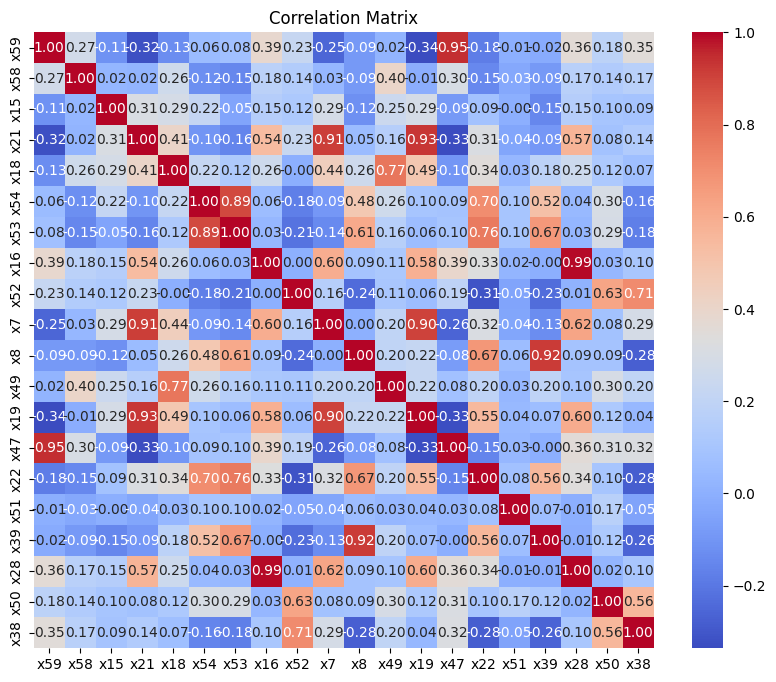

In [31]:
# heatmap
correlation_matrix = prep_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [47]:
# Split Data into Features and Labels

X_input = prep_data  # Input features
y_target = final_data[target_cols]  # Output labels

In [48]:
print(f"Shape of 'X' :{X_input.shape}")
print(f"Shape of 'y' :{y_target.shape}")

Shape of 'X' :(9811, 20)
Shape of 'y' :(9811, 33)


In [49]:
X_input.columns

Index(['x59', 'x58', 'x15', 'x21', 'x18', 'x54', 'x53', 'x16', 'x52', 'x7',
       'x8', 'x49', 'x19', 'x47', 'x22', 'x51', 'x39', 'x28', 'x50', 'x38'],
      dtype='object')

In [50]:
X_input.dtypes.unique()

array([dtype('float64')], dtype=object)

## Model Training

1. Decision Tree
2. Random Forest
3. XGboost

Decision Tree Model

In [51]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_input, y_target, test_size=0.2, random_state=42)

In [52]:
# Train Decision Tree model
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

y_pred_decision_tree = decision_tree_model.predict(X_test)
DT_accuracy = accuracy_score(y_test, y_pred_decision_tree)

print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_decision_tree)*100} %")
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_decision_tree))

Decision Tree Accuracy: 53.89709628120224 %
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.38      0.41        16
           1       0.00      0.00      0.00         0
           2       0.30      0.41      0.35        34
           3       0.62      0.51      0.56        35
           4       0.00      0.00      0.00         1
           5       0.44      0.48      0.46       146
           6       0.24      0.28      0.26        58
           7       0.00      0.00      0.00         0
           8       0.26      0.24      0.25       149
           9       0.50      0.50      0.50        32
          10       0.00      0.00      0.00         1
          11       0.38      0.43      0.40       134
          12       0.45      0.38      0.42        26
          13       0.00      0.00      0.00         0
          14       0.14      0.12      0.13         8
          15       0.22      0.25      0.24        16


c:\0_ProjectTask\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\0_ProjectTask\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\0_ProjectTask\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest Model

In [53]:
# Train Random Forest model
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

y_pred_random_forest = random_forest_model.predict(X_test)
RF_accuracy = accuracy_score(y_test, y_pred_random_forest)

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_random_forest)*100}%")
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_random_forest))

Random Forest Accuracy: 58.17626082526745%
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        16
           1       0.00      0.00      0.00         0
           2       0.93      0.41      0.57        34
           3       0.94      0.43      0.59        35
           4       0.00      0.00      0.00         1
           5       0.73      0.39      0.51       146
           6       0.85      0.19      0.31        58
           7       0.00      0.00      0.00         0
           8       0.88      0.10      0.18       149
           9       0.83      0.31      0.45        32
          10       0.00      0.00      0.00         1
          11       0.69      0.35      0.47       134
          12       0.75      0.23      0.35        26
          13       0.00      0.00      0.00         0
          14       1.00      0.12      0.22         8
          15       1.00      0.25      0.40        16
 

c:\0_ProjectTask\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\0_ProjectTask\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\0_ProjectTask\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBoost Model

In [54]:
# Train XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
XGB_accuracy = accuracy_score(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)*100}%")
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 56.13856342333163%
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.25      0.38        16
           1       0.00      0.00      0.00         0
           2       0.81      0.50      0.62        34
           3       0.94      0.46      0.62        35
           4       0.00      0.00      0.00         1
           5       0.64      0.44      0.52       146
           6       0.68      0.33      0.44        58
           7       0.00      0.00      0.00         0
           8       0.57      0.14      0.23       149
           9       0.75      0.47      0.58        32
          10       0.00      0.00      0.00         1
          11       0.54      0.38      0.45       134
          12       0.55      0.23      0.32        26
          13       0.00      0.00      0.00         0
          14       1.00      0.12      0.22         8
          15       0.75      0.19      0.30        16
          16 

c:\0_ProjectTask\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\0_ProjectTask\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\0_ProjectTask\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
# Find the Best Model and Its Accuracy

best_models = {
    'Decision Tree': decision_tree_model,
    'Random Forest': random_forest_model,
    'XGBoost': xgb_model
}

best_accuracies = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    best_accuracies[name] = accuracy

In [57]:
# Find the best model
best_model_name = max(best_accuracies, key=best_accuracies.get)
best_model = best_models[best_model_name]
best_accuracy = best_accuracies[best_model_name]

print("Best Model:", best_model_name)
print("Accuracy:", best_accuracy)

Best Model: Random Forest
Accuracy: 0.5817626082526745


In [42]:
# Save the Best Model as a pickle file
filename = 'best__model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

We got best_model.pkl file. Now we can use this model to make prediction on unseen data. 